# Photo Classifier: Model training

## Imports and configuration

In [1]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%load_ext autoreload
%autoreload 2
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary
import logging
import random
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets

In [3]:
from constants import *
from image_transforms import IMAGE_TRANSFORMS
from plotting import imshow_tensor, show_image
from learner import Learner
from data_loader import DataLoader
from image_data import ImageData
from model import get_pretrained_vgg16
from file_io import save_pickle_file

In [4]:
random.seed(42)
logging.basicConfig(level=logging.INFO)

## Data loading and grouping to training, validation and test set

In [5]:
data_loader = DataLoader()
data = data_loader.get_labeled_image_data(SOURCE_DATA_PATH)

In [6]:
image_data = ImageData(data, P_TRAINING, P_VALID, P_TEST)

## Image preprocessing

In [7]:
@interact(index=widgets.IntSlider(min=0, max=10, step=1, value=0, continuous_update=False))
def show(index=0, data_set_name=['training', 'validation', 'test']):
    label = image_data.get_label(index, data_set_name)
    image = image_data.get_image(index, data_set_name)
    show_image(image, label)

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10), Dropdown(descr…

In [8]:
test_image = image_data.get_image(0, 'training')
training_transforms = IMAGE_TRANSFORMS['training']

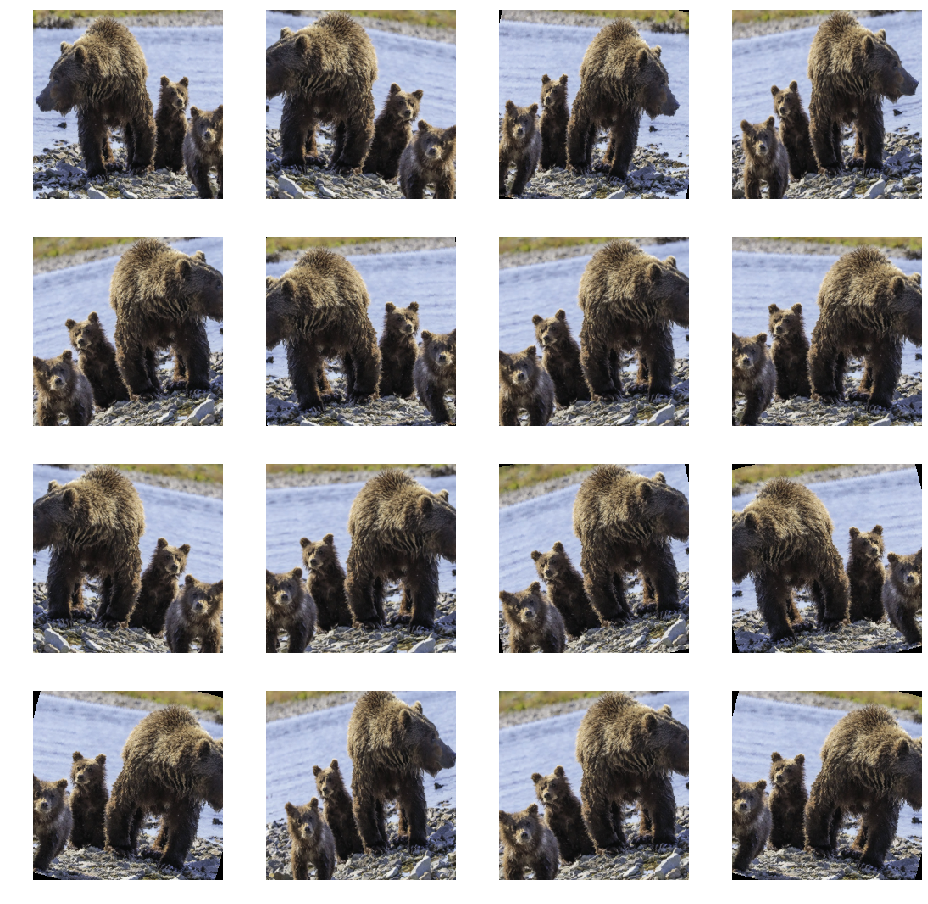

In [9]:
_ = plt.figure(figsize=(16,16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    transformed_image = training_transforms(test_image)
    _ = imshow_tensor(transformed_image, ax=ax, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

## Model

In [10]:
n_classes = len(image_data.labels)
model = get_pretrained_vgg16(n_classes)

In [11]:
summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [6, 64, 224, 224]           1,792
              ReLU-2          [6, 64, 224, 224]               0
            Conv2d-3          [6, 64, 224, 224]          36,928
              ReLU-4          [6, 64, 224, 224]               0
         MaxPool2d-5          [6, 64, 112, 112]               0
            Conv2d-6         [6, 128, 112, 112]          73,856
              ReLU-7         [6, 128, 112, 112]               0
            Conv2d-8         [6, 128, 112, 112]         147,584
              ReLU-9         [6, 128, 112, 112]               0
        MaxPool2d-10           [6, 128, 56, 56]               0
           Conv2d-11           [6, 256, 56, 56]         295,168
             ReLU-12           [6, 256, 56, 56]               0
           Conv2d-13           [6, 256, 56, 56]         590,080
             ReLU-14           [6, 256,

## Model training

In [12]:
learner = Learner(model)
losses, losses_valid = learner.fit_model(image_data,
                                        image_transforms_training=IMAGE_TRANSFORMS['training'],
                                        image_transforms_validation=IMAGE_TRANSFORMS['validation'],
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY,
                                        early_stop_option=USE_EARLY_STOP)

INFO:learner:
            Epoch: 1/15
            Validation loss: 0.42364010214805603
INFO:learner:
            Epoch: 2/15
            Validation loss: 0.15598608553409576
INFO:learner:
            Epoch: 3/15
            Validation loss: 0.15199591219425201
INFO:learner:
            Epoch: 4/15
            Validation loss: 0.1426859349012375
INFO:learner:
            Epoch: 5/15
            Validation loss: 0.14145806431770325
INFO:learner:
            Epoch: 6/15
            Validation loss: 0.12167415767908096
INFO:learner:
            Epoch: 7/15
            Validation loss: 0.1269432157278061
INFO:learner:Early stop criterion filled; fitting completed!


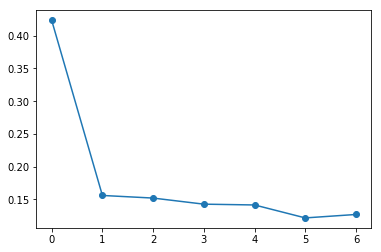

In [13]:
_ = plt.plot(losses_valid, '-o')

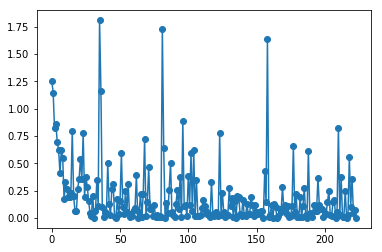

In [14]:
_ = plt.plot(losses, '-o')

## Save data and model

In [15]:
save_pickle_file(learner, MODEL_FILE_PATH)
save_pickle_file(image_data, IMAGE_DATA_PATH)